# Welcome to wizarding World

In [ ]:
# !pip install tensorflow_decision_forests
!pip install tensorflow==2.8.0
!pip install tensorflow_decision_forests==0.2.4
!pip install sklearn==0.21.3
import os
import math
import time 
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_decision_forests as tfdf
from tensorflow.python.data.ops import dataset_ops
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497.6 MB 1.8 kB/s 
     |████████████████████████████████| 462 kB 56.6 MB/s 
     |████████████████████████████████| 5.8 MB 56.6 MB/s 
     |████████████████████████████████| 1.4 MB 63.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.4 MB 15.2 MB/s 
Looking in indexes: ht

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [ ]:
pwd = "/content/drive/MyDrive/ML_Final/data/harry_all_drop.csv"

data = read_csv(pwd, on_bad_lines='skip')

# for i in data.columns:
#   print(i)
kill_list = ['books', 'language_books', 'movies', 'language_movies', 'Sorting_completed_YN', 'country', 'language', 'Bravery', 'Hardwork', 'Intelligence', 'Ambition', 'Daring', 'Dedication', 'Knowledge', 'Cunning', 'Extraverted', 'Agreeable', 'Clever', 'Manipulative']
data = data.drop(kill_list, axis=1)


for i in data.columns:
  if 'PVQ' in i:
    data = data.drop(i, axis=1)
print(data.columns)


for col in data.columns:
  if col == 'Sorting_house':
    for i in range(0, len(data[col])):
      if data[col].iloc[i] == 'Gryffindor':
        data[col].iloc[i] = 1
      elif data[col].iloc[i] == 'Ravenclaw':
        data[col].iloc[i] = 2
      elif data[col].iloc[i] == 'Hufflepuff':
        data[col].iloc[i] = 3
      else: # data[col].iloc[i] == 'Slytherin'
        data[col].iloc[i] = 4
  elif col == 'Sorting_house_wish':
    for i in range(0, len(data[col])):
      if data[col].iloc[i] == 'Gryffindor':
        data[col].iloc[i] = 1
      elif data[col].iloc[i] == 'Ravenclaw':
        data[col].iloc[i] = 2
      elif data[col].iloc[i] == 'Hufflepuff':
        data[col].iloc[i] = 3
      else: # data[col].iloc[i] == 'Slytherin'
        data[col].iloc[i] = 4
  elif col == 'age':
    for i in range(0, len(data[col])):
      int(data[col].iloc[i])
    data = data.drop(data[data.age > 100].index)
  elif col == 'occupation':
    for i in range(0, len(data[col])):
      if data[col].iloc[i] == 'Student':
        data[col].iloc[i] = 1
      elif data[col].iloc[i] == 'Employed':
        data[col].iloc[i] = 2
      elif data[col].iloc[i] == 'Unemployed':
        data[col].iloc[i] = 3
      else:
        data[col].iloc[i] = 4
  elif col == 'gender':
    for i in range(0, len(data[col])):
      if data[col].iloc[i] == 'Female':
        data[col].iloc[i] = 1
      elif data[col].iloc[i] == 'Male':
        data[col].iloc[i] = 2
  else:
    for i in range(0, len(data[col])):
      int(data[col].iloc[i])



Index(['Sorting_house', 'Sorting_house_wish', 'age', 'occupation', 'gender',
       'SD3_Machiavellianism', 'SD3_Narcissism', 'SD3_Psychopathy',
       'IPIP_Extraversion', 'IPIP_Agreeableness', 'IPIP_Conscientiousness',
       'IPIP_EmStability', 'IPIP_Intellect'],
      dtype='object')


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
Y_DATA = np.asarray(data['Sorting_house']).reshape((986, 1)).astype('float32')
Y_train = Y_DATA[:800]
Y_valid = Y_train[720:]
Y_test = Y_DATA[800:]

DATA = np.asarray(data.drop('Sorting_house', axis=1)).astype('float32')
X_train = DATA[:800]
X_valid = X_train[720:]
X_test = DATA[800:]

print("X_train: ", X_train.shape)
print("X_valid: ", X_valid.shape)
print("Y_train: ", Y_train.shape)
print("Y_valid: ", Y_valid.shape)

X_train:  (800, 12)
X_valid:  (80, 12)
Y_train:  (800, 1)
Y_valid:  (80, 1)


# Tensorflow Decision Forest

In [ ]:
# Maximum number of decision trees. The effective number of trained trees can be smaller if early stopping is enabled.
NUM_TREES = 50
# Minimum number of examples in a node.
MIN_EXAMPLES = 8
# Maximum depth of the tree. max_depth=1 means that all trees will be roots.
MAX_DEPTH = 10
# Ratio of the dataset (sampling without replacement) used to train individual trees for the random sampling method.
SUBSAMPLE = 0.5
# Control the sampling of the datasets used to train individual trees.
SAMPLING_METHOD = "RANDOM"
# Ratio of the training dataset used to monitor the training. Require to be >0 if early stopping is enabled.
VALIDATION_RATIO = 0.1

In [ ]:
gbt_model = tfdf.keras.GradientBoostedTreesModel(
        # features=specify_feature_usages(),
        # exclude_non_specified_features=True,
        num_trees=NUM_TREES,
        max_depth=MAX_DEPTH,
        min_examples=MIN_EXAMPLES,
        subsample=SUBSAMPLE,
        validation_ratio=VALIDATION_RATIO,
        task=tfdf.keras.Task.CLASSIFICATION
        # check_dataset=False
)

gbt_model.compile(metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

Use /tmp/tmp0jefsoi3 as temporary training directory


In [ ]:
num_epochs = 1
batch_size = 32

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.batch(batch_size)
# valid_data = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
gbt_model.fit(train_data, epochs=num_epochs, batch_size=batch_size)

Starting reading the dataset
10/25 [===========>..................] - ETA: 0s  
Dataset read in 0:00:03.713519
Training model
Model trained in 0:00:01.132100
Compiling model
25/25 [==============================] - 5s 53ms/step


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


6/6 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.6720
Test accuracy: 67.2%
              precision    recall  f1-score   support

           1       0.68      0.65      0.67        43
           2       0.83      0.70      0.76        69
           3       0.62      0.63      0.63        41
           4       0.51      0.70      0.59        33

    accuracy                           0.67       186
   macro avg       0.66      0.67      0.66       186
weighted avg       0.69      0.67      0.68       186



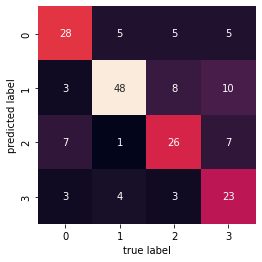

In [ ]:
valid_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
valid_data = valid_data.batch(batch_size)
predict, accuracy = gbt_model.evaluate(valid_data, verbose=1)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# gbt_model.predict(valid_data, verbose=1)

Y_pred = gbt_model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1).reshape(186, 1)
print(metrics.classification_report(Y_pred, Y_test))

mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# sklearn Random Forest Classifier

<ipython-input-9-3557b793fad5>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, Y_train)


              precision    recall  f1-score   support

         1.0       0.61      0.76      0.68        33
         2.0       0.90      0.69      0.78        75
         3.0       0.74      0.66      0.70        47
         4.0       0.51      0.74      0.61        31

    accuracy                           0.70       186
   macro avg       0.69      0.71      0.69       186
weighted avg       0.74      0.70      0.71       186



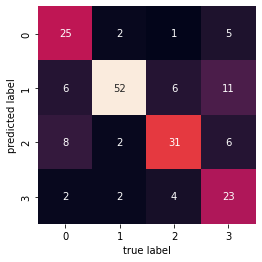

In [ ]:
# tree = DecisionTreeClassifier()
# #通過每個估計器擬合80％的訓練點
# bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
# bag.fit(X, y)
# visualize_classifier(bag, X, y)
rf_model = RandomForestClassifier(n_estimators=1000, random_state=1)
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)
print(metrics.classification_report(Y_pred, Y_test))

mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# sklearn Decision Tree
[Reference: Multi-class Classification using Decision-Tree Model](https://adityagoel123.medium.com/multi-class-classification-using-decision-tree-model-68e75114303)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
model_gini = DecisionTreeClassifier(criterion = 'gini', random_state = 50, max_depth = 3, min_samples_leaf = 5)
model_gini = model_gini.fit(X_train, Y_train)
print(model_gini)
model_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 50, max_depth = 3, min_samples_leaf = 5)
model_entropy = model_entropy.fit(X_train, Y_train)
print(model_entropy)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=50)
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=50)


In [ ]:
Y_pred_gini = model_gini.predict(X_test)
print("Y_pred_gini: ", Y_pred_gini)
Y_pred_entropy = model_entropy.predict(X_test)
print("Y_pred_entropy: ",Y_pred_entropy)

Y_pred_gini:  [4. 1. 3. 2. 2. 1. 2. 3. 1. 2. 1. 1. 4. 1. 3. 1. 3. 2. 2. 3. 3. 3. 1. 2.
 2. 4. 2. 4. 2. 2. 2. 3. 2. 2. 3. 4. 3. 4. 1. 4. 2. 1. 2. 4. 2. 2. 4. 2.
 1. 2. 1. 1. 1. 1. 3. 3. 3. 2. 2. 1. 3. 4. 2. 4. 4. 3. 4. 2. 4. 3. 4. 1.
 4. 1. 2. 4. 1. 1. 3. 4. 4. 2. 3. 1. 3. 3. 2. 3. 2. 2. 2. 3. 3. 2. 2. 2.
 3. 1. 2. 2. 2. 3. 2. 3. 2. 2. 4. 3. 1. 1. 3. 1. 2. 3. 2. 2. 3. 2. 4. 1.
 3. 2. 2. 3. 2. 2. 2. 3. 1. 4. 3. 2. 4. 2. 2. 3. 4. 4. 2. 1. 4. 4. 2. 2.
 1. 1. 2. 2. 2. 2. 3. 4. 3. 1. 2. 1. 2. 2. 3. 3. 2. 2. 2. 3. 2. 2. 3. 4.
 3. 2. 2. 1. 2. 4. 3. 3. 2. 1. 2. 2. 1. 2. 2. 3. 1. 2.]
Y_pred_entropy:  [4. 1. 3. 2. 2. 1. 2. 3. 1. 2. 1. 1. 4. 1. 3. 1. 3. 2. 2. 3. 3. 3. 1. 2.
 2. 4. 2. 4. 2. 2. 2. 3. 2. 2. 3. 4. 3. 4. 1. 4. 2. 1. 2. 4. 2. 2. 4. 2.
 1. 2. 1. 3. 1. 1. 3. 3. 3. 2. 2. 3. 3. 4. 2. 4. 4. 3. 4. 2. 4. 3. 4. 1.
 4. 1. 2. 4. 1. 1. 3. 4. 4. 2. 3. 1. 3. 3. 2. 3. 2. 2. 2. 3. 3. 2. 2. 2.
 3. 1. 2. 2. 2. 3. 2. 3. 2. 2. 4. 3. 1. 1. 3. 1. 2. 3. 2. 2. 3. 2. 4. 1.
 3. 2. 2. 3. 2. 2. 2. 3. 1. 4. 3. 2. 

              precision    recall  f1-score   support

         1.0       0.78      0.68      0.73        41
         2.0       0.72      0.93      0.81        58
         3.0       0.64      0.69      0.67        42
         4.0       0.77      0.51      0.61        45

    accuracy                           0.72       186
   macro avg       0.73      0.70      0.70       186
weighted avg       0.73      0.72      0.71       186



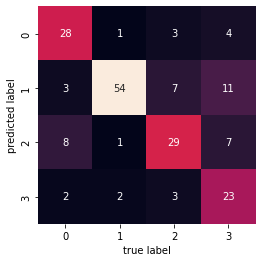

In [ ]:
print(classification_report(Y_test, Y_pred_gini))
mat = confusion_matrix(Y_test, Y_pred_gini)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

              precision    recall  f1-score   support

         1.0       0.82      0.68      0.75        41
         2.0       0.72      0.93      0.81        58
         3.0       0.66      0.74      0.70        42
         4.0       0.77      0.51      0.61        45

    accuracy                           0.73       186
   macro avg       0.74      0.72      0.72       186
weighted avg       0.74      0.73      0.72       186



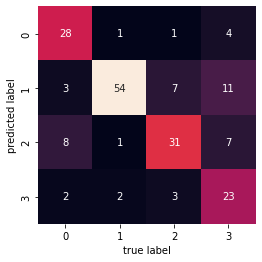

In [ ]:
print(classification_report(Y_test, Y_pred_entropy))
mat = confusion_matrix(Y_test, Y_pred_entropy)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

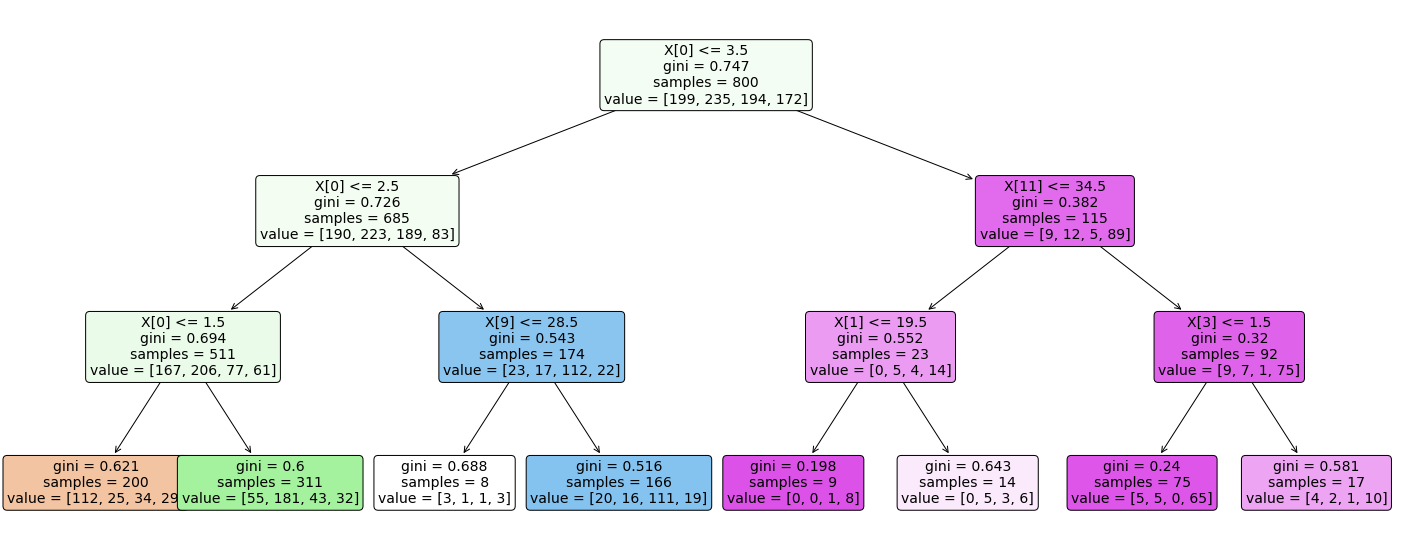

In [ ]:
plt.figure(figsize = (25,10))
a = plot_tree(model_gini,
        filled = True,
        rounded = True,
        fontsize = 14)
plt.savefig("decisiontree_gini.png")

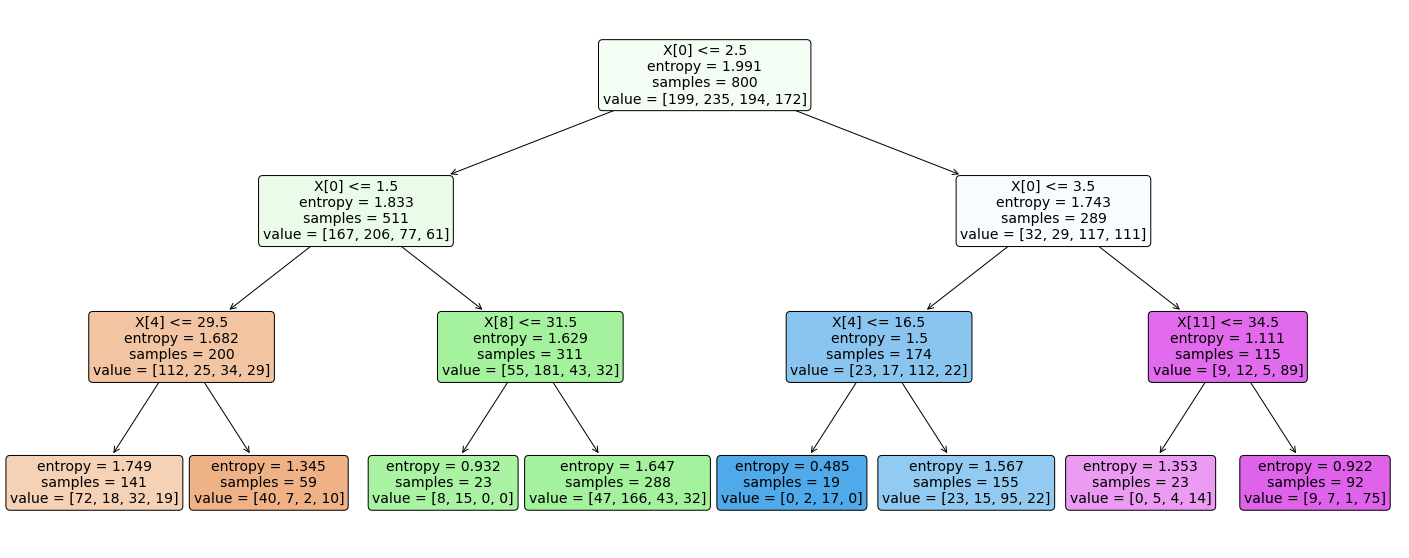

In [ ]:
plt.figure(figsize = (25,10))
a = plot_tree(model_entropy,
        filled = True,
        rounded = True,
        fontsize = 14)
plt.savefig("decisiontree_entropy.png")

## save model

In [ ]:
import joblib
joblib.dump(model_entropy, 'model_entropy')

['model_entropy']

# sklearn Random Forest

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix
# from sklearn.externals import joblib

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

In [ ]:
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
# classifier.fit(X_train, Y_train)

In [ ]:
# Predicting the Test set results
# y_pred = classifier.predict(X_test)
# print("y_pred: ", y_pred)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# reversefactor = dict(zip(range(3),definitions))
# y_test = np.vectorize(reversefactor.get)(y_test)
# y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
# print(pd.crosstab(y_test, y_pred, rownames=['Assigned House'], colnames=['Predicted House']))

# Predict
[Short Dark Triad (SD3)](https://journals.sagepub.com/doi/abs/10.1177/1073191113514105?journalCode=asma)

[IPIP scale](https://ipip.ori.org/New_IPIP-50-item-scale.htm)

In [ ]:
#@title Input information
from google.colab import files
import os.path
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

Sorting_house_wish = "Gryffindor" #@param ["Gryffindor", "Ravenclaw", "Hufflepuff", "Slytherin"]

age = 23 #@param {type:"integer"}

occupation = "Student" #@param ["Student", "Employed", "Unemployed", "Others"]

gender = "Female" #@param ["Female", "Male"]

In [ ]:
#@title Short Dark Triad (SD3) Machiavellianism
#@markdown Do a brief measurement to measure your dark side

#@markdown *Strongly disagree* = 1, *Disagree* = 2, *Neither agree nor disagree* = 3, *Agree* = 4, *Strongly agree* = 5

#@markdown 1. It's not wise to tell your secret.
SD3_M1 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 2.	I like to use clever manipulation to get my way.
SD3_M2 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 3. Whatever it takes, you must get the important people on your side.
SD3_M3 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 4.	Avoid direct conflict with others because they may be useful in the future.
SD3_M4 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 5.	It’s wise to keep track of information that you can use against people later.
SD3_M5 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 6.	You should wait for the right time to get back at people.
SD3_M6 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 7.	There are things you should hide from other people to preserve your reputation.
SD3_M7 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 8.	Make sure your plans benefit yourself, not others.
SD3_M8 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 9.	Most people can be manipulated.
SD3_M9 = 3 #@param [1,2,3,4,5] {type:"raw"}

In [ ]:
#@title Short Dark Triad (SD3) Narcissism
#@markdown Do a brief measurement to measure your dark side

#@markdown *Strongly disagree* = 1, *Disagree* = 2, *Neither agree nor disagree* = 3, *Agree* = 4, *Strongly agree* = 5

#@markdown 1. People see me as a natural leader.
SD3_N1 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 2.	I hate being the center of attention. (R)
SD3_N2 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 3. Many group activities tend to be dull without me
SD3_N3 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 4.	I know that I am special because everyone keeps telling me so.
SD3_N4 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 5.	I like to get acquainted with important people.
SD3_N5 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 6.	I feel embarrassed if someone compliments me. (R)
SD3_N6 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 7.	I have been compared to famous people.
SD3_N7 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 8.	I am an average person. (R)
SD3_N8 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 9.	I insist on getting the respect I deserve.
SD3_N9 = 3 #@param [1,2,3,4,5] {type:"raw"}

In [ ]:
#@title Short Dark Triad (SD3) Psychopathy
#@markdown Do a brief measurement to measure your dark side

#@markdown *Strongly disagree* = 1, *Disagree* = 2, *Neither agree nor disagree* = 3, *Agree* = 4, *Strongly agree* = 5

#@markdown 1. I like to get revenge on authorities.
SD3_P1 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 2.	I avoid dangerous situations. (R)
SD3_P2 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 3. Payback needs to be quick and nasty.
SD3_P3 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 4.	People often say I’m out of control.
SD3_P4 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 5.	It’s true that I can be mean to others.
SD3_P5 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 6.	People who mess with me always regret it.
SD3_P6 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 7.	I have never gotten into trouble with the law. (R)
SD3_P7 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 8.	I enjoy having sex with people I hardly know
SD3_P8 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 9.	I’ll say anything to get what I want.
SD3_P9 = 3 #@param [1,2,3,4,5] {type:"raw"}

In [ ]:
#@title IPIP Measures Questionnaire Extraversion
#@markdown Do a brief measurement to measure your dark side

#@markdown *Very Inaccurate* = 1, *Moderately Inaccurate* = 2, *Neither Accurate Nor Inaccurate* = 3, *Moderately Accurate* = 4, *Very Accurate* = 5

#@markdown 1. Am the life of the party.
IPIP_01 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 2.	Feel little concern for others.
IPIP_02 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 3. Am always prepared.
IPIP_03 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 4.	Get stressed out easily.
IPIP_04 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 5.	Have a rich vocabulary.
IPIP_05 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 6.	Don't talk a lot.
IPIP_06 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 7.	Am interested in people.
IPIP_07 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 8.	Leave my belongings around.
IPIP_08 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 9.	Am relaxed most of the time.
IPIP_09 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 10. Have difficulty understanding abstract ideas.
IPIP_10 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 11. Feel comfortable around people.
IPIP_11 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 12. Insult people.
IPIP_12 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 13. Pay attention to details.
IPIP_13 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 14. Worry about things.
IPIP_14 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 15. Have a vivid imagination.
IPIP_15 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 16. Keep in the background.
IPIP_16 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 17. Sympathize with others' feelings.
IPIP_17 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 18. Make a mess of things.
IPIP_18 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 19. Seldom feel blue.
IPIP_19 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 20. Am not interested in abstract ideas.
IPIP_20 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 21. Start conversations.
IPIP_21 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 22. Am not interested in other people's problems.
IPIP_22 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 23. Get chores done right away.
IPIP_23 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 24. Am easily disturbed.
IPIP_24 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 25. Have excellent ideas.
IPIP_25 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 26. Have little to say.
IPIP_26 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 27. Have a soft heart.
IPIP_27 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 28. Often forget to put things back in their proper place.
IPIP_28 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 29. Get upset easily.
IPIP_29 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 30. Do not have a good imagination.
IPIP_30 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 31. Talk to a lot of different people at parties.
IPIP_31 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 32. Am not really interested in others.
IPIP_32 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 33. Like order.
IPIP_33 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 34. Change my mood a lot.
IPIP_34 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 35. Am quick to understand things.
IPIP_35 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 36. Don't like to draw attention to myself.
IPIP_36 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 37. Take time out for others.
IPIP_37 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 38. Shirk my duties.
IPIP_38 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 39. Have frequent mood swings.
IPIP_39 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 40. Use difficult words.
IPIP_40 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 41. Don't mind being the center of attention.
IPIP_41 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 42. Feel others' emotions.
IPIP_42 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 43. Follow a schedule.
IPIP_43 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 44. Get irritated easily.
IPIP_44 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 45. Spend time reflecting on things.
IPIP_45 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 46. Am quiet around strangers.
IPIP_46 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 47. Make people feel at ease.
IPIP_47 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 48. Am exacting in my work.
IPIP_48 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 49. Often feel blue.
IPIP_49 = 3 #@param [1,2,3,4,5] {type:"raw"}
#@markdown 50. Am full of ideas.
IPIP_50 = 3 #@param [1,2,3,4,5] {type:"raw"}

## Process Data

In [ ]:
SD3_Machiavellianism = SD3_M1 + SD3_M2 + SD3_M3 + SD3_M4 + SD3_M5 + SD3_M6 + SD3_M7 + SD3_M8 + SD3_M9
SD3_Narcissism = SD3_N1 + SD3_N2 + SD3_N3 + SD3_N4 + SD3_N5 + SD3_N6 + SD3_N7 + SD3_N8 + SD3_N9
SD3_Psychopathy = SD3_P1 + SD3_P2 + SD3_P3 + SD3_P4 + SD3_P5 + SD3_P6 + SD3_P7 + SD3_P8 + SD3_P9
IPIP_Extraversion = IPIP_01 - IPIP_06 + IPIP_11 - IPIP_16 + IPIP_21 - IPIP_26 + IPIP_31 - IPIP_36 + IPIP_41 - IPIP_46
IPIP_Agreeableness = -IPIP_02 + IPIP_07 - IPIP_12 + IPIP_17 - IPIP_22 + IPIP_27 - IPIP_32 + IPIP_37 + IPIP_42 + IPIP_47
IPIP_Conscientiousness = IPIP_03 - IPIP_08 + IPIP_13 - IPIP_18 + IPIP_23 - IPIP_28 + IPIP_33 - IPIP_38 + IPIP_43 + IPIP_48
IPIP_EmStability = -IPIP_04 + IPIP_09 - IPIP_14 + IPIP_19 - IPIP_24 - IPIP_29 - IPIP_34 - IPIP_39 - IPIP_44 - IPIP_49
IPIP_Intellect = IPIP_05 - IPIP_10 + IPIP_15 - IPIP_20 + IPIP_25 - IPIP_30 + IPIP_35 + IPIP_40 + IPIP_45 + IPIP_50

In [ ]:
if Sorting_house_wish == 'Gryffindor':
  Sorting_house_wish = 1
elif Sorting_house_wish == 'Ravenclaw':
  Sorting_house_wish = 2
elif Sorting_house_wish == 'Hufflepuff':
  Sorting_house_wish = 3
else: #Sorting_house_wish == 'Slytherin'
  Sorting_house_wish = 4

if occupation == 'Student':
  occupation = 1
elif occupation == 'Employed':
  occupation = 2
elif occupation == 'Unemployed':
  occupation = 3
else:
  occupation = 4

if gender == 'Female':
  gender = 1
elif gender == 'Male':
  gender = 2

X_test = np.array([Sorting_house_wish, age, occupation, gender,
       SD3_Machiavellianism, SD3_Narcissism, SD3_Psychopathy,
       IPIP_Extraversion, IPIP_Agreeableness, IPIP_Conscientiousness,
       IPIP_EmStability, IPIP_Intellect]).reshape(1, -1)
Y_test_gini = model_gini.predict(X_test)
Y_test_entropy = model_entropy.predict(X_test)
Y_test_gbt = np.argmax(gbt_model.predict(X_test))
Y_test_rf = np.argmax(rf_model.predict(X_test))
print(Y_test_rf)
# max = np.max(Y_test_gbt)
# ans = Y_test_gini + Y_test_entropy
# for i in range(len(Y_test_gbt[0])):
#   if Y_test_gbt[0][i] == max:
#     ans_gbt = (i+1)

# ans = int(Y_test_entropy+ans_gbt)
# if ans/3 >= 3.5:
#   print('WELCOME TO SLYTHERIN!')
# elif ans/3 >= 2.5:
#   print('WELCOME TO HUFFLEPUFF!')
# elif ans/3 >= 1.5:
#   print('WELCOME TO RAVENCLAW!')
# else: #ans/3 >= 0.5:
#   print('WELCOME TO GRYFFINDOR!')

if Y_test_rf == 4:
  print('WELCOME TO SLYTHERIN!')
elif Y_test_rf == 3:
  print('WELCOME TO HUFFLEPUFF!')
elif Y_test_rf == 2:
  print('WELCOME TO RAVENCLAW!')
else: #ans/3 >= 0.5:
  print('WELCOME TO GRYFFINDOR!')


0
WELCOME TO GRYFFINDOR!
